<a href="https://colab.research.google.com/github/mequanent/Bioinformatics-hws/blob/main/hw5_110761504%20UPGMA%20and%20NJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HW5: UPGMA and NJ** 

In [1]:
!npx degit https://github.com/mequanent/Bioinformatics-hws -f

npx: installed 1 in 2.704s
> destination directory is not empty. Using --force, continuing
> cloned mequanent/Bioinformatics-hws#HEAD


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

input = "pro5_test4.txt"
#input = "distanceMatrix1.txt"
input = open(input, 'r')
lines = input.readlines()[1:]
input.close()

# Get the matrix in numpy form and then in pandas form
def getD(lines):
  distance = []
  indices = []
  i = 0
  for line in lines:
    line = line.split()
    distance.append(line)
    indices.append(i)
    i += 1
  # numpy and then pandas form of the distance matrix
  indices = [(chr(i+65)) for i in indices]
  distance = np.array(distance).astype(float)
  dist = pd.DataFrame(distance, index = indices, columns = indices)
  # Add additional column to store the combined entities 
  
  return dist, indices
dist, indices = getD(lines)

In [16]:
def modifyD(d):
  indices = getD(lines)[1]
  d['paired'] = indices # Column for paired taxas with their corresponding distances
  #d['paired_no_dist'] = indices # Without distance for simplified view of combination
  return d

In [17]:
def mini(a):
  loc = (0, 0)
  min = np.Inf 
  cols = [c for c in a.columns if a.columns.get_loc(c) < a.columns.get_loc('paired')]
  for i in cols:
    for j in cols: 
      if i != j:
        if a.loc[i][j] < min:
          min = a.loc[i][j]
          loc = (i, j)  
  return min, loc

In [26]:
# A function to update the distance in UPGMA 
# Reference for updating table: http://www.slimsuite.unsw.edu.au/teaching/upgma/
def updateD(D):
  d = getD(lines)[0]

  i, j = mini(D)[1]

  D = D.rename(columns={j: i + j}, index={j: i + j}) # Rename index and column
  D.drop(i, inplace = True) # drop one
  D.drop(i, inplace = True, axis = 1)
  j = i + j

  cols = [c for c in D.columns if D.columns.get_loc(c) < D.columns.get_loc('paired')]
  for u in cols:
    if u == j:
      D.loc[u, j] = 0
    else:
      sum = 0
      l = len(j) * len(u)
      for x in j:
        for y in u:
          sum = sum + d.loc[x, y]
      D.loc[j, u] = D.loc[u, j] = sum/l
  return D 

You should consider the # of elements when recalculating the distance matrix after merging two taxa.
Taking merging (a,b) & e as an example, how to calculate the distance between a cluster, ((a,b),e), and c = (D((a,b),c)x2 + D(e,c)x1) / (2+1) instead of (D((a,b),c) + D(e,c)) / 2.
I would discuss this in the next lecture.
Therefore, the deadline for pro5 is postponed to 00:00 10th of June. 

Thanks, Mequanent for pointing out the difference between Average linkage clustering: WPGMA and  Average linkage clustering: UPGMA.

In [30]:
def UPGMA():
  D = getD(lines)[0]
  D = modifyD(D)
  D['Dso_far'] = 0 # distance accumulated  so far
  while len(D) > 1:
    min_dist, loc = mini(D)
    i, j = loc#min(loc), max(loc)
    half = round(min_dist / 2, 4) # round result to 4 decimal places
    #print(i, j)
    print(min_dist, i, D.loc[i]['Dso_far'], j, D.loc[j]['Dso_far'])
    #print(j, D.loc[j]['Dso_far'])
    #print(D)
    
    d1, d2 = half - D.loc[i]['Dso_far'], half - D.loc[j]['Dso_far']
    d1, d2 = str(round(d1, 3)), str(round(d2, 3)) # rounded to 3 as in the expected output
    
    p1, p2 = D.loc[i]['paired'], D.loc[j]['paired']
    #p11, p22 = D.loc[i]['paired_no_dist'], D.loc[j]['paired_no_dist']

    #cols = [c for c in D.columns if D.columns.get_loc(c) < D.columns.get_loc('paired')]
    D = updateD(D)

    pair = "(" + p1 + ':' + d1 + ", " + p2 + ':' + d2 + ")"  # form paired string
    #pair_no_dist = "(" + p11 +  ", " + p22 + ")" 

    D.loc[i+j, 'paired'] = pair
    #D.loc[i+j, 'paired_no_dist'] = pair_no_dist
    D.loc[i+j, 'Dso_far'] = half

  #D['paired'] = D['paired'] + ";"
  #D['paired_no_dist'] = D['paired_no_dist'] + ";"
  return D['paired'][0]#, D['paired_no_dist'][0]
print('With distance:')
print(UPGMA())#[0])
print('Without distance:')
#print(UPGMA()[1]) 

With distance:
0.0824 A 0 B 0
0.1532 D 0.0 G 0.0
0.3121 C 0.0 F 0.0
0.4175 AB 0.0412 H 0.0
0.4881 E 0.0 DG 0.0766
0.5602666666666666 CF 0.156 ABH 0.2088
0.6146266666666667 EDG 0.244 CFABH 0.2801
((E:0.244, (D:0.077, G:0.077):0.167):0.063, ((C:0.156, F:0.156):0.124, ((A:0.041, B:0.041):0.168, H:0.209):0.071):0.027)
Without distance:


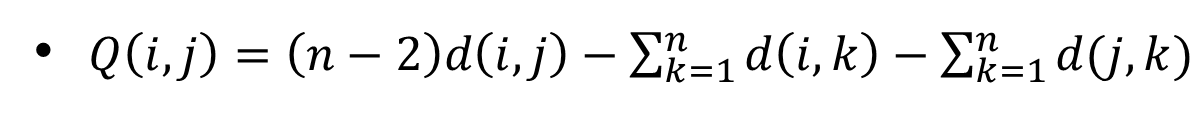

In [ ]:
# Get the sum of all distances for each taxa 
def getsum(d): 
  cols = [col for col in d.index]
  sums = dict()
  for i in cols:
    sums[i] = d.loc[i, :'paired'][:-1].sum()
  return sums

In [ ]:
# Calculate Q for the a distance matrix
def getQ(D):
  n = len(D) 
  Q = D.copy()

  cols = [c for c in D.columns if D.columns.get_loc(c) < D.columns.get_loc('paired')]
  for i in cols:
    for j in cols:  
      if i != j:  
        dif = getsum(D)[i] + getsum(D)[j]
        Q.loc[i, j] = round(((n-2) * D.loc[i][j] - dif), 3)
        Q.loc[j, i] = Q.loc[i, j]
  return Q    

In [ ]:
# The neighbor joining method
def NJ():
  D = getD(lines)[0]
  D = modifyD(D)  
  #D = getD(lines)
  while len(D) > 1:
    n = len(D)
    q = getQ(D)
    min_dist, loc = mini(q)
    f, g = min(loc), max(loc)

    p1, p2 = D.loc[f]['paired'], D.loc[g]['paired']
    p11, p22 = D.loc[f]['paired_no_dist'], D.loc[g]['paired_no_dist']

    dist1 = getsum(D)[f]
    dist2 = getsum(D)[g]
    if len(D) > 2:
      dif = (dist1 - dist2) / (n-2)
      delta_fu = round((0.5 * (D.loc[f][g] + dif)), 2)
      delta_gu = round((D.loc[f][g] - delta_fu), 2)
    else:
      delta_gu = round((0.5 * (D.loc[f][g] + dist1)), 2)
      delta_fu = ''

    if len(D) == 2:
      pair = "(" + p2 + ':' + str(delta_gu) + ", " + p1  + ")"  # form paired string
      pair_no_dist = "(" + p22 +  ", " + p11 + ")" 
    elif len(D) == 3:
      pair = p2 + ':' + str(delta_gu) + ", " + p1 + ':' + str(delta_fu)# + ")"  # form paired string
      pair_no_dist = p22 +  ", " + p11 
    else:
      pair = "(" + p2 + ':' + str(delta_gu) + ", " + p1 + ':' + str(delta_fu) + ")"  # form paired string
      pair_no_dist = "(" + p22 +  ", " + p11 + ")"

    tmp = D.copy()
    D.drop(g, inplace = True) # Remove one row considering f as u
    D.drop(g, inplace = True, axis = 1) # Remove one column
    
    cols = [col for col in D.columns if col not in [f, 'paired', 'paired_no_dist']]
    for k in cols:    
      D.loc[f, k] = round((0.5 * (tmp.loc[f, k] + tmp.loc[g, k] - tmp.loc[f, g])), 3)
      D.loc[k, f] = D.loc[f, k]    # Column 

    D.loc[f, 'paired'] = pair
    D.loc[f, 'paired_no_dist'] = pair_no_dist
  return D['paired'][0], D['paired_no_dist'][0]
print('With distance:')
print(NJ()[0])
print('Without distance:')
print(NJ()[1])

With distance:
((G:0.12, F:0.15):0.04, E:0.15, (D:0.28, (C:0.36, (B:0.77, A:0.92):0.42):0.05):0.03)
Without distance:
((G, F), E, (D, (C, (B, A))))


In [24]:
method = 'UPGMA'
tree = []
if method == 'UPGMA':
  tree = UPGMA()
elif method == 'NJ':
  tree = NJ()
print(tree[0])
print(tree[1])

(
(


In [ ]:
!pip install Bio -q
from Bio import Phylo
from io import StringIO

     |████████████████████████████████| 270 kB 4.2 MB/s 
     |████████████████████████████████| 2.3 MB 55.2 MB/s 


Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.04)
            Clade(branch_length=0.12, name='G')
            Clade(branch_length=0.15, name='F')
        Clade(branch_length=0.15, name='E')
        Clade(branch_length=0.03)
            Clade(branch_length=0.28, name='D')
            Clade(branch_length=0.05)
                Clade(branch_length=0.36, name='C')
                Clade(branch_length=0.42)
                    Clade(branch_length=0.77, name='B')
                    Clade(branch_length=0.92, name='A')


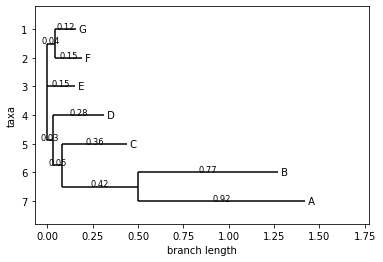

In [ ]:
tree = Phylo.read(StringIO(tree[0]), "newick")
print(tree)
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)
#Phylo.write(tree, "example-both.nwk", "newick")

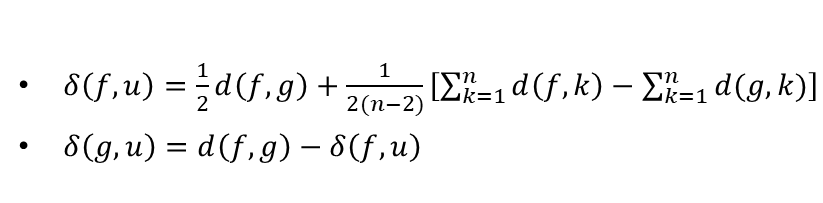

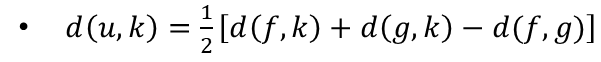